In [ ]:
#%load_ext cudf.pandas
import pandas as pd
import numpy as np
import os
import pickle
import gzip


# Set random seeds to ensure repeatability
SEED = 2024

def set_seeds(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    rng = np.random.default_rng(seed)

    return rng

rng = set_seeds(SEED)

In [ ]:
# read zip file from google drive
from google.colab import drive
drive.mount('/content/drive')#,timeout_ms=300000, force_remount=True, readonly=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#first_pass_data_brd4={'Xtr':Xtr,'ytr':ytr,'Xval':Xval,'yval':yval,'Xte':Xte,'yte':yte}

file_path = "/content/drive/My Drive"+os.sep+"Belka_Data"+os.sep

with gzip.open(file_path+"brd4_alone_trainTest.pkl.zip",'rb') as f: #brd4_alone_balanced_trainTest.pkl
  data = pickle.load(f)

In [ ]:
# Import tools for data splits and model development
from sklearn.model_selection import StratifiedKFold

# for computing performance metrics
from sklearn.metrics import roc_auc_score,average_precision_score
from sklearn.metrics import confusion_matrix as cfmatrix

# compute all performance metrics for evaluation
def getMetrics(ytr,cm,th=0.5):
  tn, fp, fn, tp = cfmatrix(ytr, cm>th).ravel()

  auc = roc_auc_score(ytr,cm)
  ap = average_precision_score(ytr,cm)
  acc = (tp+tn)/(tp+tn+fp+fn)
  sens = tp/(tp+fn)
  spes = tn/(fp+tn)
  ppv = tp/(tp+fp)
  npv = tn/(tn+fn)


  return pd.Series([auc,ap,tp,fp,fn,tn,th,acc,sens,spes,ppv,npv],index=['AUC','AUCPR','TP','FP','FN','TN','Threshold',
                                                                        'Acc','Sensitivity','Specificity','Precision','NPV'])

In [ ]:
'''

# Training data -- I am combining validation data here because the search will be using CV

# using morgan finger print features that showed better promise for BRD4 classification
Xtm = np.concatenate((data['Xtr'][1],data['Xval'][1]),axis=0)
Xtr = np.concatenate((data['Xtr'][2],data['Xval'][2]),axis=0)
ytr = np.concatenate((data['ytr'],data['yval']))

Xtem = data['Xte'][1]
Xte = data['Xte'][2]
yte = data['yte']

print(Xtr.shape)
'''
# Training data -- using validation data for pure testing

# using morgan finger print features that showed better promise for BRD4 classification
Xtm = data['Xtr'][1]
Xtr = data['Xtr'][2]
ytr =data['ytr']

Xtem = data['Xval'][1]
Xte =data['Xval'][2]
yte = data['yval']

'''
Xtem = data['Xte'][1]
Xte = data['Xte'][2]
yte = data['yte']
'''
print(Xtr.shape)

(724499, 1024)


#XGBoost

Until now we have shown the model development provess from the simple logistic model to the final selected Random Forest model. We will now implement an optimized version of the boosted tree model to compare against the best random forest performance. If random forest performance cannot be surpassed, we will select that as our final model for further analysis.

Reduce training samples because 720000 overwhelms XGB

In [ ]:
import xgboost as xgb

In [ ]:
dtra=xgb.DMatrix(Xtm,label=ytr)

In [ ]:
# params to tune
pars = {'max_depth':4,'min_child_weight':10,'eta':.1,'subsample':0.8,'colsample_bytree':0.9,'objective':'binary:logistic','eval_metric':'aucpr','scale_pos_weight':500}
num_boost_round=1000
early_stop=10

In [ ]:
cv_result= xgb.cv(pars, dtra, num_boost_round=num_boost_round,
                  seed=SEED, nfold=10, metrics = {'aucpr'}, early_stopping_rounds = early_stop)



In [ ]:
cv_result.iloc[-1,:]

,57
train-aucpr-mean,0.032700
train-aucpr-std,0.004643
test-aucpr-mean,0.027180
test-aucpr-std,0.009072


In [ ]:
# tune number of boosting rounds
rounds=100
mod=xgb.train(pars, dtra, num_boost_round=rounds)

In [ ]:
xmod=[mod]
# build xgb models for each set of 32 features

for k in range(32):
  cod=np.arange(k*32,(k+1)*32)
  dtra=xgb.DMatrix(Xtr[:,cod],label=ytr)
  mod1=xgb.train(pars, dtra, num_boost_round=rounds)
  xmod.append(mod1)


In [ ]:
#collect all predictions from the first set of 33 models on the training data
dtra=xgb.DMatrix(Xtm,label=ytr)
mod=xmod[0]

preds=np.zeros((Xtm.shape[0],33))

preds[:,0] = mod.predict(dtra)

for k in range(32):
  cod=np.arange(k*32,(k+1)*32)
  dtra=xgb.DMatrix(Xtr[:,cod],label=ytr)
  mod =xmod[k+1]
  preds[:,k+1] = mod.predict(dtra)

In [ ]:
#combine results into an xgb model
dtra=xgb.DMatrix(preds,label=ytr)

sup_mod=xgb.train(pars, dtra, num_boost_round=rounds)

In [ ]:
xmod.append(sup_mod)

In [ ]:
# Save model
import pickle
file_name = file_path+'Trained_Models'+os.sep+'xgb_parts_model_1031feats.pkl'

data = {'xgb_model':xmod,'info': 'trained with 4 max depth and 400 trees on 32 morgan finger prints each and 7 mol feats first and sup_mod-combined of everything last, +ve weighted 1000' }
with open(file_name,'wb') as f:
  pickle.dump(data,f)

In [ ]:
#setup validation data

dval=xgb.DMatrix(Xtem,label=yte)
mod=xmod[0]

pval=np.zeros((Xtem.shape[0],33))

pval[:,0] = mod.predict(dval)

for k in range(32):
  cod=np.arange(k*32,(k+1)*32)
  dval=xgb.DMatrix(Xte[:,cod],label=yte)
  mod =xmod[k+1]
  pval[:,k+1] = mod.predict(dval)


dval = xgb.DMatrix(pval,label=yte)

In [ ]:
cm = sup_mod.predict(dtra)
metr = getMetrics(ytr,cm)

ct = sup_mod.predict(dval)
mete = getMetrics(yte,ct)

print('Training results')
preval = np.sum(ytr==1)/len(ytr)
print(metr)
print(preval,metr['Precision'],metr['Precision']/preval)

print('Testing results')
preval = np.sum(yte==1)/len(yte)
print(mete)
print(preval,mete['Precision'],mete['Precision']/preval)

Training results
AUC                 0.996262
AUCPR               0.418971
TP               1182.000000
FP              21636.000000
FN                 18.000000
TN             701663.000000
Threshold           0.500000
Acc                 0.970112
Sensitivity         0.985000
Specificity         0.970087
Precision           0.051801
NPV                 0.999974
dtype: float64
0.0016563169859447702 0.051801209571391005 31.274937111052676
Testing results
AUC                 0.961570
AUCPR               0.280903
TP                421.000000
FP               9480.000000
FN                 93.000000
TN             300505.000000
Threshold           0.500000
Acc                 0.969169
Sensitivity         0.819066
Specificity         0.969418
Precision           0.042521
NPV                 0.999691
dtype: float64
0.0016553998563602458 0.04252095747904252 25.68621551806464


In [ ]:
from sklearn.linear_model import LogisticRegressionCV as LCV

lr=LCV(cv=5, max_iter=100000, class_weight='balanced', random_state=SEED)

In [ ]:
lr.fit(Xtrain,ytrain)

In [ ]:
cv_result= xgb.cv(pars, dtra, num_boost_round=num_boost_round,
                  seed=SEED, nfold=10, metrics = {'aucpr'}, early_stopping_rounds = early_stop)

cv_result

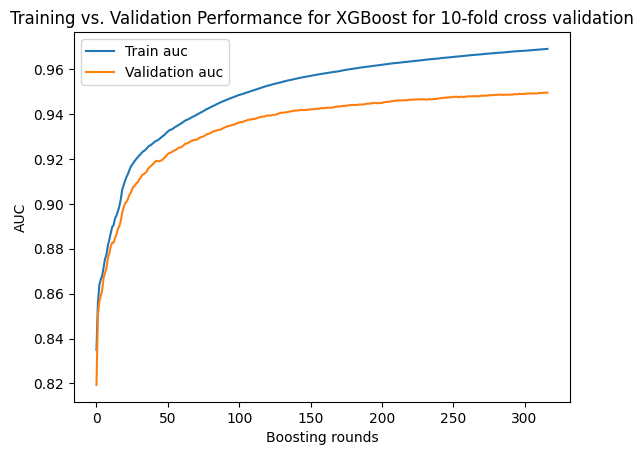

In [ ]:
plt.plot(cv_result['train-auc-mean'],label='Train auc')
plt.plot(cv_result['test-auc-mean'], label='Validation auc')
plt.xlabel('Boosting rounds')
plt.ylabel('AUC')
plt.title('Training vs. Validation Performance for XGBoost for 10-fold cross validation')
plt.legend()
plt.show()

In [ ]:
# tune number of boosting rounds
mod=xgb.train(pars, dtra, num_boost_round=317)

In [ ]:
cm =mod.predict(dtra)

cm

array([0.10688997, 0.19877408, 0.00736442, ..., 0.13370499, 0.02533835,
       0.15970433], dtype=float32)

In [ ]:
cm =mod.predict(dtra)

ct = mod.predict(dval)

modelPerformance.loc[len(modelPerformance.index),:]=['XGB_AllMF','(317,2)',
                                                     Xtr.shape[0],100*np.sum(ytr)/Xtr.shape[0],roc_auc_score(ytr,cm),
                                                     Xte.shape[0],100*np.sum(yte)/Xte.shape[0],roc_auc_score(yte,ct)]

modelPerformance

,Model,#Parameters,Train Data points,Train positive fraction %,Train AUC,Val Data points,Val positive fraction %,Val AUC
0,Logistic_BPF,7,2400,50.0,0.783459,1028,50.0,0.781942
1,Logistic_SMF,5,2400,50.0,0.827317,1028,50.0,0.817344
2,RF_SMF,"Logistic 4 (10,4)",2400,50.0,0.827728,1028,50.0,0.820285
3,RF_SBMF,"23 AUC>0.6 (500,8)",2400,50.0,0.884209,1028,50.0,0.864423
4,RF_AllMF,"1024MF (500,8)",2400,50.0,0.974584,1028,50.0,0.947452
5,RF_SelMF,"375 F (500,6)",2400,50.0,0.954887,1028,50.0,0.93872
6,XGB_AllMF,"(317,2)",2400,50.0,0.969031,1028,50.0,0.958993


<Axes: >

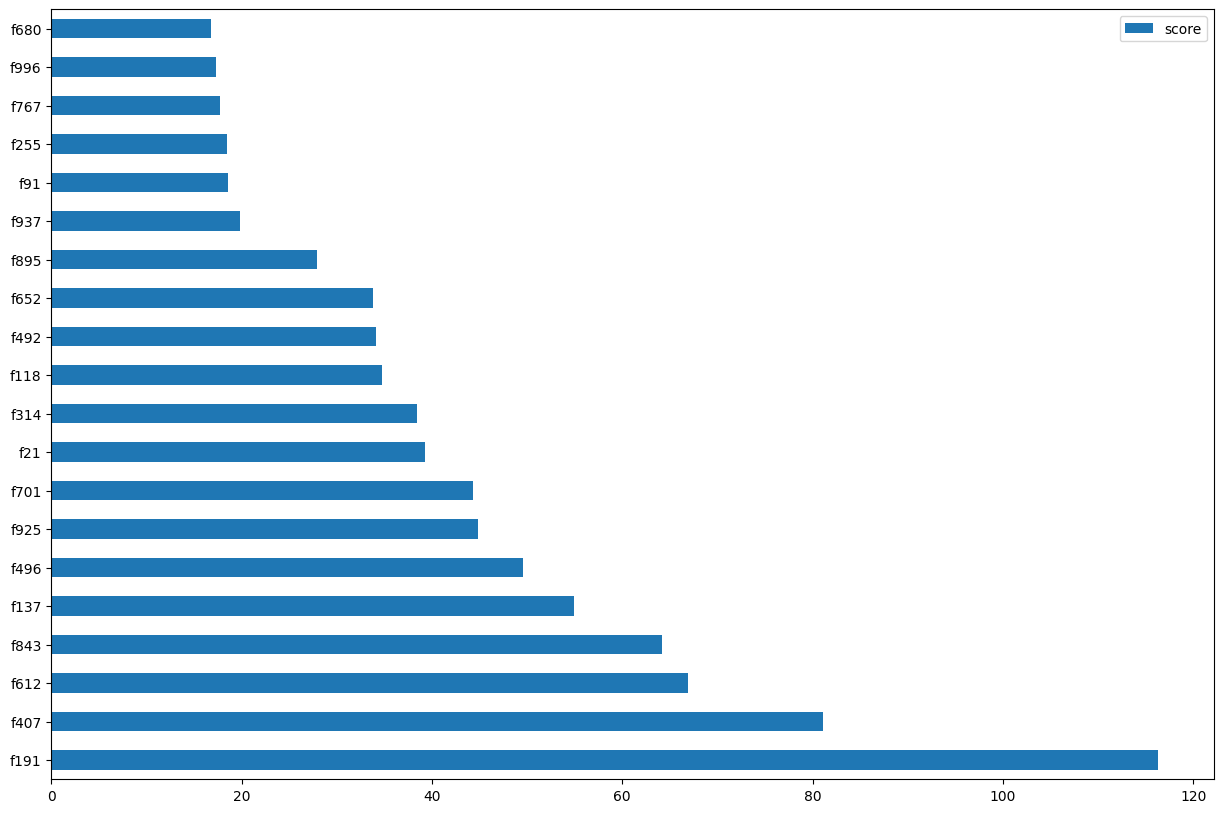

In [ ]:
feature_important = mod.get_score(importance_type='gain')
keys = list(feature_important.keys())
values = list(feature_important.values())


data = pd.DataFrame(data=values, index=keys, columns=["score"])
data.score=-data.score.values
data=data.sort_values(by = "score", ascending=False)
data.score=-data.score.values
data.nlargest(20, columns="score").plot(kind='barh', figsize = (15,10)) ## plot top 40 features

In [ ]:
values= np.array(list(feature_important.values()))
keys = list(feature_important.keys())

keys = np.array(list(map(lambda x:int(x.split('f')[1]), keys)))

keys



array([  4,   5,  13,  15,  19,  21,  33,  36,  37,  42,  64,  71,  73,
        75,  77,  90,  91,  92,  94, 107, 112, 114, 117, 118, 119, 136,
       137, 138, 158, 171, 175, 188, 191, 200, 202, 209, 212, 219, 231,
       249, 255, 257, 266, 268, 278, 283, 294, 301, 310, 314, 315, 322,
       324, 325, 329, 333, 342, 352, 361, 364, 366, 367, 381, 385, 386,
       392, 407, 428, 433, 448, 456, 457, 464, 482, 486, 488, 489, 492,
       496, 500, 511, 518, 523, 543, 549, 554, 555, 557, 561, 562, 571,
       573, 578, 579, 580, 606, 607, 612, 613, 614, 618, 621, 632, 633,
       637, 638, 646, 652, 653, 656, 659, 661, 667, 672, 675, 679, 680,
       694, 695, 698, 699, 701, 703, 707, 714, 716, 721, 726, 730, 734,
       736, 739, 749, 753, 758, 759, 767, 784, 787, 802, 804, 806, 816,
       818, 832, 841, 843, 874, 875, 881, 885, 887, 895, 925, 926, 935,
       937, 939, 940, 946, 950, 959, 967, 980, 996, 997])

In [ ]:
isel = np.argsort(-values)
val=values[isel]
for k in range(1024):
 rk = (np.sum(val[:k])/np.sum(val))
 if rk > 0.95:
  print(k)
  break


132


In [ ]:
iselect = keys[isel[:k]]
iselect

array([191, 407, 612, 843, 137, 496, 925, 701,  21, 314, 118, 492, 652,
       895, 937,  91, 255, 767, 996, 680,  37, 633, 578, 202, 940, 107,
        94, 325,   5,  71, 694, 268, 428, 632, 511, 385, 716, 482, 939,
       249, 959, 257, 283, 322, 950, 278, 818, 557, 158,  75, 392, 679,
       500, 646, 112, 315, 554, 885, 361, 656, 784, 638, 352, 324, 703,
       367, 946, 579, 136, 637, 887, 753, 749, 488, 661, 555, 695, 621,
       699, 329, 721, 464,  15, 875, 802, 758, 607, 707, 518, 188, 562,
       675,  19, 523, 739, 806, 832, 841, 171, 456, 301,  33, 433, 653,
       726, 486,  90, 734, 219,  77, 200, 294, 138, 759, 804, 881, 935,
       448, 816, 614, 457, 489, 730, 618,  42, 549, 667,  73, 543, 980,
       613, 231])

In [ ]:
dtra=xgb.DMatrix(Xtr[:,iselect],label=ytr)
dval=xgb.DMatrix(Xte[:,iselect],label=yte)

In [ ]:
cv_result= xgb.cv(pars, dtra, num_boost_round=num_boost_round,
                  seed=seed, nfold=10, metrics = {'auc'}, early_stopping_rounds = early_stop)

cv_result

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.832601,0.007871,0.818507,0.031122
1,0.860000,0.003327,0.855233,0.013888
2,0.864575,0.002770,0.858902,0.013151
3,0.866026,0.003456,0.860186,0.011695
4,0.868396,0.003004,0.863007,0.013074
...,...,...,...,...
273,0.965457,0.000681,0.950374,0.008621
274,0.965506,0.000662,0.950555,0.008649
275,0.965551,0.000652,0.950548,0.008801
276,0.965598,0.000661,0.950625,0.008794


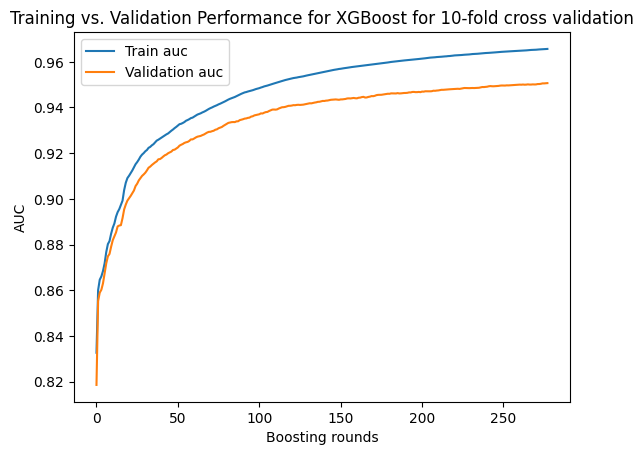

In [ ]:
plt.plot(cv_result['train-auc-mean'],label='Train auc')
plt.plot(cv_result['test-auc-mean'], label='Validation auc')
plt.xlabel('Boosting rounds')
plt.ylabel('AUC')
plt.title('Training vs. Validation Performance for XGBoost for 10-fold cross validation')
plt.legend()
plt.show()

In [ ]:
# tune number of boosting rounds
mod=xgb.train(pars, dtra, num_boost_round=278)

In [ ]:
cm =mod.predict(dtra)

ct = mod.predict(dval)

modelPerformance.loc[len(modelPerformance.index),:]=['XGB_SelMF','132MF (278,2)',
                                                     Xtr.shape[0],100*np.sum(ytr)/Xtr.shape[0],roc_auc_score(ytr,cm),
                                                     Xte.shape[0],100*np.sum(yte)/Xte.shape[0],roc_auc_score(yte,ct)]

modelPerformance

,Model,#Parameters,Train Data points,Train positive fraction %,Train AUC,Val Data points,Val positive fraction %,Val AUC
0,Logistic_BPF,7,2400,50.0,0.783459,1028,50.0,0.781942
1,Logistic_SMF,5,2400,50.0,0.827317,1028,50.0,0.817344
2,RF_SMF,"Logistic 4 (10,4)",2400,50.0,0.827728,1028,50.0,0.820285
3,RF_SBMF,"23 AUC>0.6 (500,8)",2400,50.0,0.884209,1028,50.0,0.864423
4,RF_AllMF,"1024MF (500,8)",2400,50.0,0.974584,1028,50.0,0.947452
5,RF_SelMF,"375 F (500,6)",2400,50.0,0.954887,1028,50.0,0.93872
6,XGB_AllMF,"(317,2)",2400,50.0,0.969031,1028,50.0,0.958993
7,XGB_SelMF,"132MF (278,2)",2400,50.0,0.966066,1028,50.0,0.957153


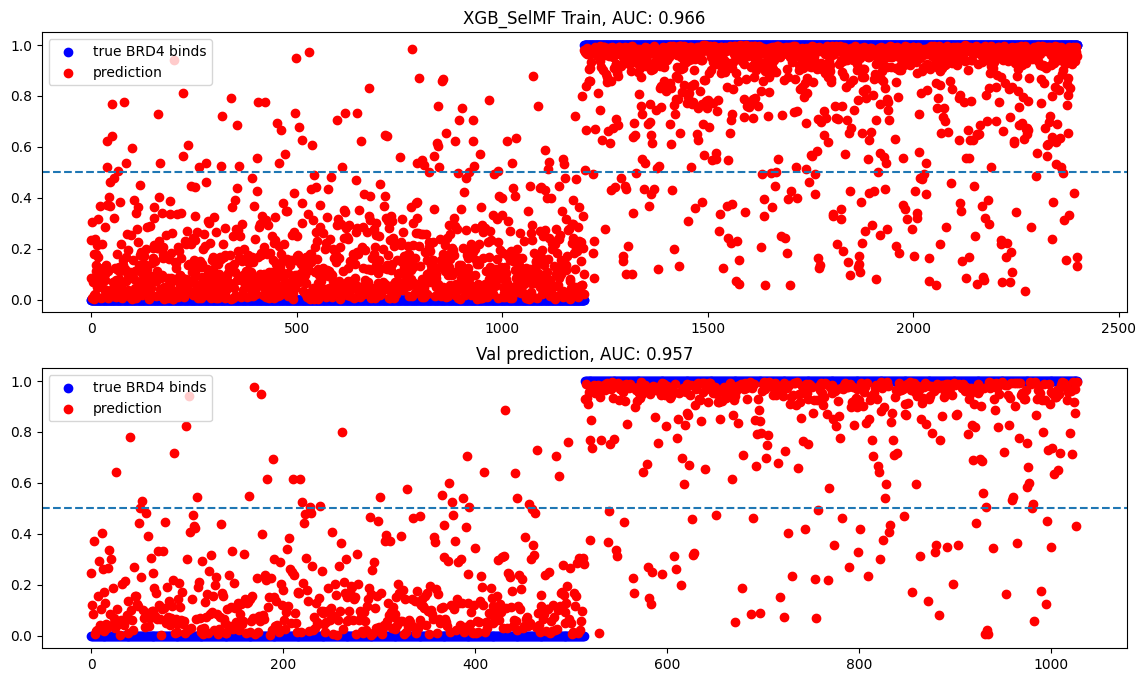

In [ ]:
l11,l12,l21,l22=np.sum(ytr==0),np.sum(ytr==1),np.sum(yte==0),np.sum(yte==1)


ytru = np.concatenate((ytr[ytr==0],ytr[ytr==1]))
ctr =np.concatenate((cm[ytr==0],cm[ytr==1]))

yteu = np.concatenate((yte[yte==0],yte[yte==1]))
cte =np.concatenate((ct[yte==0],ct[yte==1]))


plt.figure(figsize=(14,8))
plt.subplot(2,1,1)
plt.scatter(np.arange(l11+l12),ytru,color='b',label='true BRD4 binds')
plt.axhline(y=0.5,xmin=0,xmax=l11+l12,linestyle='--')
plt.scatter(np.arange(l11+l12),ctr,color='r',label='prediction')
plt.title(f"XGB_SelMF Train, AUC: {np.round(modelPerformance.loc[7,'Train AUC'],3)}")
plt.legend()
plt.subplot(2,1,2)
plt.scatter(np.arange(l21+l22),yteu,color='b',label='true BRD4 binds')
plt.axhline(y=0.5,xmin=0,xmax=l21+l22,linestyle='--')
plt.scatter(np.arange(l21+l22),cte,color='r',label='prediction')
plt.title(f"Val prediction, AUC: {np.round(modelPerformance.loc[7,'Val AUC'],3)}")
plt.legend()
plt.show()

In [ ]:
import pickle
model_file = "/content/drive/My Drive"+os.sep+"Belka_Data"+os.sep

data={'xgb_model':mod,'info': 'Trained on Xtr from brd4_alone_balanced_trainTest.pkl and validated on Xval morgan finger prints','selected_features':iselect}
with open(model_file+"xgb_model_brd4.pkl", "wb") as f:
  pickle.dump(data, f)

In [ ]:
cm =mod.predict(dtra)

ct = mod.predict(dval)

In [ ]:
print('This is for the best XGBoost model selMF 132 F (278,2)')

print('Training result - Threshold 0.5 -- not AUC')
print(clasrep(ytr,cm>0.5))
print(cfmatrix(ytr,cm>0.5))


print('Validation result - Threshold 0.5 -- not AUC')
print(clasrep(yte,ct>0.5))
print(cfmatrix(yte,ct>0.5))

This is for the best XGBoost model selMF 132 F (278,2)
Training result - Threshold 0.5 -- not AUC
              precision    recall  f1-score   support

           0       0.89      0.93      0.91      1200
           1       0.93      0.88      0.91      1200

    accuracy                           0.91      2400
   macro avg       0.91      0.91      0.91      2400
weighted avg       0.91      0.91      0.91      2400

[[1121   79]
 [ 139 1061]]
Validation result - Threshold 0.5 -- not AUC
              precision    recall  f1-score   support

           0       0.88      0.93      0.90       514
           1       0.93      0.87      0.90       514

    accuracy                           0.90      1028
   macro avg       0.90      0.90      0.90      1028
weighted avg       0.90      0.90      0.90      1028

[[479  35]
 [ 68 446]]


## Apply Features selected by XGBoost to Random Forest
Train a random forest model with the same 132 features

In [ ]:
rf = RFC(random_state=seed,n_estimators = 278, max_depth =6)

rf.fit(Xtr[:,iselect],ytr)

cmrf =rf.predict_proba(Xtr[:,iselect])

ctrf = rf.predict_proba(Xte[:,iselect])

'''
modelPerformance.loc[len(modelPerformance.index),:]=['RF_SelMF','132F (278,6)',
                                                     Xtr.shape[0],100*np.sum(ytr)/Xtr.shape[0],roc_auc_score(ytr,cm[:,1]),
                                                     Xte.shape[0],100*np.sum(yte)/Xte.shape[0],roc_auc_score(yte,ct[:,1])]
'''
modelPerformance

,Model,#Parameters,Train Data points,Train positive fraction %,Train AUC,Val Data points,Val positive fraction %,Val AUC
0,Logistic_BPF,7,2400,50.0,0.783459,1028,50.0,0.781942
1,Logistic_SMF,5,2400,50.0,0.827317,1028,50.0,0.817344
2,RF_SMF,"Logistic 4 (10,4)",2400,50.0,0.827728,1028,50.0,0.820285
3,RF_SBMF,"23 AUC>0.6 (500,8)",2400,50.0,0.884209,1028,50.0,0.864423
4,RF_AllMF,"1024MF (500,8)",2400,50.0,0.974584,1028,50.0,0.947452
5,RF_SelMF,"375 F (500,6)",2400,50.0,0.954887,1028,50.0,0.93872
6,XGB_AllMF,"(317,2)",2400,50.0,0.969031,1028,50.0,0.958993
7,XGB_SelMF,"132MF (278,2)",2400,50.0,0.966066,1028,50.0,0.957153
8,RF_SelMF,"132F (278,2)",2400,50.0,0.897174,1028,50.0,0.891866
9,RF_SelMF,"132F (278,4)",2400,50.0,0.93041,1028,50.0,0.918674


In [ ]:
print('This is for the best random forest model selMF 132 MF (278,6)')

print('Training result - Threshold 0.5 -- not AUC')
print(clasrep(ytr,cmrf[:,1]>0.5))
print(cfmatrix(ytr,cmrf[:,1]>0.5))


print('Validation result - Threshold 0.5 -- not AUC')
print(clasrep(yte,ctrf[:,1]>0.5))
print(cfmatrix(yte,ctrf[:,1]>0.5))

This is for the best random forest model selMF 132 MF (278,6)
Training result - Threshold 0.5 -- not AUC
              precision    recall  f1-score   support

           0       0.84      0.94      0.89      1200
           1       0.93      0.82      0.87      1200

    accuracy                           0.88      2400
   macro avg       0.88      0.88      0.88      2400
weighted avg       0.88      0.88      0.88      2400

[[1124   76]
 [ 212  988]]
Validation result - Threshold 0.5 -- not AUC
              precision    recall  f1-score   support

           0       0.83      0.94      0.88       514
           1       0.93      0.81      0.87       514

    accuracy                           0.88      1028
   macro avg       0.88      0.88      0.88      1028
weighted avg       0.88      0.88      0.88      1028

[[484  30]
 [ 96 418]]


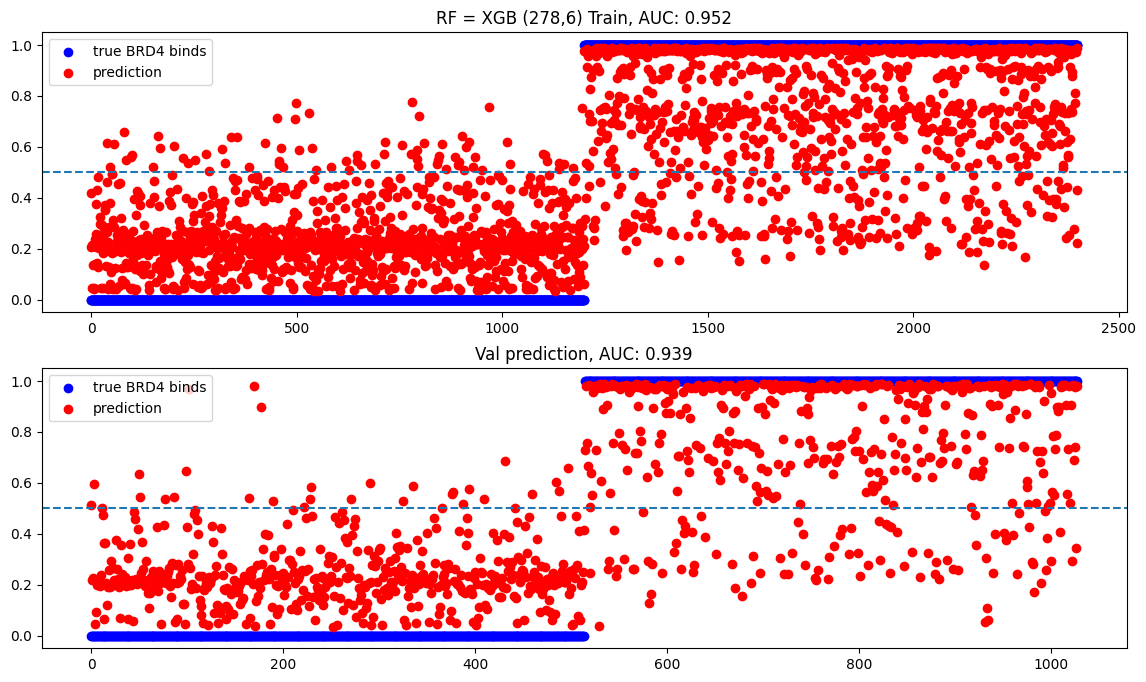

In [ ]:
l11,l12,l21,l22=np.sum(ytr==0),np.sum(ytr==1),np.sum(yte==0),np.sum(yte==1)


ytru = np.concatenate((ytr[ytr==0],ytr[ytr==1]))
ctr =np.concatenate((cm[ytr==0,1],cm[ytr==1,1]))

yteu = np.concatenate((yte[yte==0],yte[yte==1]))
cte =np.concatenate((ct[yte==0,1],ct[yte==1,1]))


plt.figure(figsize=(14,8))
plt.subplot(2,1,1)
plt.scatter(np.arange(l11+l12),ytru,color='b',label='true BRD4 binds')
plt.axhline(y=0.5,xmin=0,xmax=l11+l12,linestyle='--')
plt.scatter(np.arange(l11+l12),ctr,color='r',label='prediction')
plt.title(f"RF = XGB (278,6) Train, AUC: {np.round(modelPerformance.loc[12,'Train AUC'],3)}")
plt.legend()
plt.subplot(2,1,2)
plt.scatter(np.arange(l21+l22),yteu,color='b',label='true BRD4 binds')
plt.axhline(y=0.5,xmin=0,xmax=l21+l22,linestyle='--')
plt.scatter(np.arange(l21+l22),cte,color='r',label='prediction')
plt.title(f"Val prediction, AUC: {np.round(modelPerformance.loc[12,'Val AUC'],3)}")
plt.legend()
plt.show()

# Combine XGB and RF 132F models

In [ ]:
from sklearn.linear_model import LinearRegression as LR

lr = LR()

cmrf[:,0]=cm
ctrf[:,0]=ct

lr.fit(cmrf,ytr)


cm_final =lr.predict(cmrf)

ct_final =lr.predict(ctrf)

In [ ]:
np.mean(cm_final)

0.5

In [ ]:
print('This is for the fusion linear model 132 MF')

th=0.5
print('Training result - Threshold 0.5 -- not AUC')
print(clasrep(ytr,cm_final>th))
print(cfmatrix(ytr,cm_final>th))


print('Validation result - Threshold 0.5 -- not AUC')
print(clasrep(yte,ct_final>th))
print(cfmatrix(yte,ct_final>th))

This is for the fusion linear model 132 MF
Training result - Threshold 0.5 -- not AUC
              precision    recall  f1-score   support

           0       0.89      0.93      0.91      1200
           1       0.93      0.89      0.91      1200

    accuracy                           0.91      2400
   macro avg       0.91      0.91      0.91      2400
weighted avg       0.91      0.91      0.91      2400

[[1121   79]
 [ 135 1065]]
Validation result - Threshold 0.5 -- not AUC
              precision    recall  f1-score   support

           0       0.88      0.93      0.90       514
           1       0.92      0.87      0.90       514

    accuracy                           0.90      1028
   macro avg       0.90      0.90      0.90      1028
weighted avg       0.90      0.90      0.90      1028

[[477  37]
 [ 66 448]]


In [ ]:
modelPerformance.loc[len(modelPerformance.index),:]=['RF_XGB','132F Linear',
                                                     Xtr.shape[0],100*np.sum(ytr)/Xtr.shape[0],roc_auc_score(ytr,cm_final),
                                                     Xte.shape[0],100*np.sum(yte)/Xte.shape[0],roc_auc_score(yte,ct_final)]

In [ ]:
modelPerformance

,Model,#Parameters,Train Data points,Train positive fraction %,Train AUC,Val Data points,Val positive fraction %,Val AUC
0,Logistic_BPF,7,2400,50.0,0.783459,1028,50.0,0.781942
1,Logistic_SMF,5,2400,50.0,0.827317,1028,50.0,0.817344
2,RF_SMF,"Logistic 4 (10,4)",2400,50.0,0.827728,1028,50.0,0.820285
3,RF_SBMF,"23 AUC>0.6 (500,8)",2400,50.0,0.884209,1028,50.0,0.864423
4,RF_AllMF,"1024MF (500,8)",2400,50.0,0.974584,1028,50.0,0.947452
5,RF_SelMF,"375 F (500,6)",2400,50.0,0.954887,1028,50.0,0.93872
6,XGB_AllMF,"(317,2)",2400,50.0,0.969031,1028,50.0,0.958993
7,XGB_SelMF,"132MF (278,2)",2400,50.0,0.966066,1028,50.0,0.957153
8,RF_SelMF,"132F (278,2)",2400,50.0,0.897174,1028,50.0,0.891866
9,RF_SelMF,"132F (278,4)",2400,50.0,0.93041,1028,50.0,0.918674


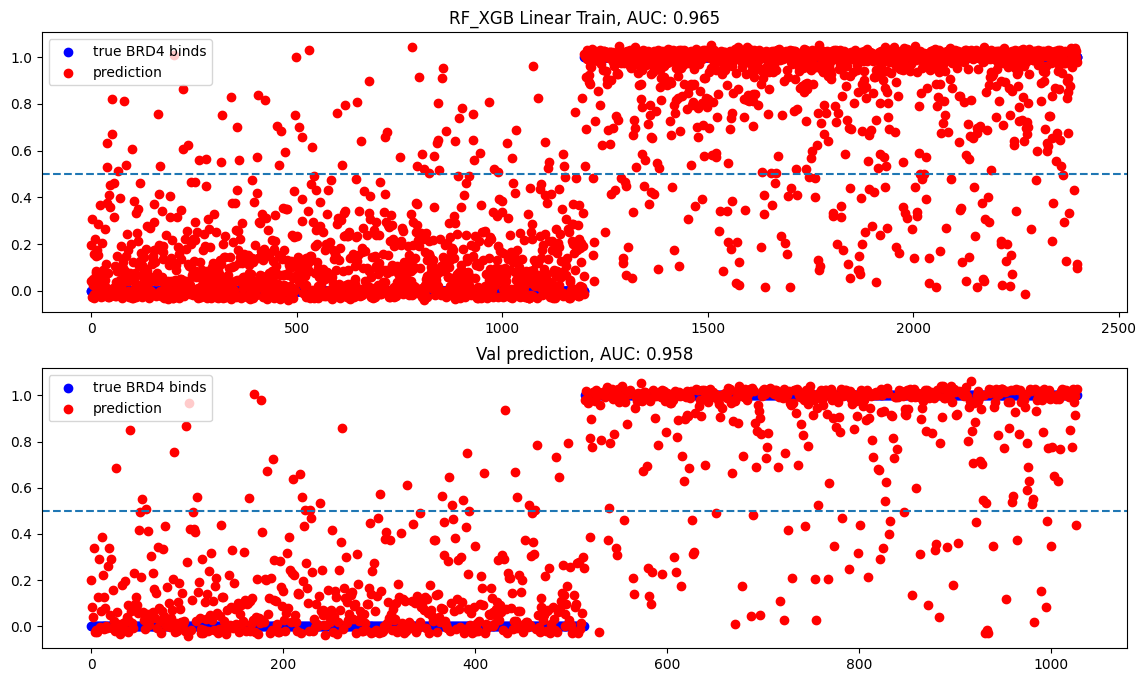

In [ ]:
l11,l12,l21,l22=np.sum(ytr==0),np.sum(ytr==1),np.sum(yte==0),np.sum(yte==1)


ytru = np.concatenate((ytr[ytr==0],ytr[ytr==1]))
ctr =np.concatenate((cm_final[ytr==0],cm_final[ytr==1]))

yteu = np.concatenate((yte[yte==0],yte[yte==1]))
cte =np.concatenate((ct_final[yte==0],ct_final[yte==1]))


plt.figure(figsize=(14,8))
plt.subplot(2,1,1)
plt.scatter(np.arange(l11+l12),ytru,color='b',label='true BRD4 binds')
plt.axhline(y=0.5,xmin=0,xmax=l11+l12,linestyle='--')
plt.scatter(np.arange(l11+l12),ctr,color='r',label='prediction')
plt.title(f"RF_XGB Linear Train, AUC: {np.round(modelPerformance.loc[12,'Train AUC'],3)}")
plt.legend()
plt.subplot(2,1,2)
plt.scatter(np.arange(l21+l22),yteu,color='b',label='true BRD4 binds')
plt.axhline(y=0.5,xmin=0,xmax=l21+l22,linestyle='--')
plt.scatter(np.arange(l21+l22),cte,color='r',label='prediction')
plt.title(f"Val prediction, AUC: {np.round(modelPerformance.loc[12,'Val AUC'],3)}")
plt.legend()
plt.show()

In [ ]:
# Logistic fusion

from sklearn.linear_model import LogisticRegressionCV as LCV

lr = LCV(cv=10)

#cmrf[:,0]=cm
#ctrf[:,0]=ct

lr.fit(cmrf,ytr)


cm_final =lr.predict_proba(cmrf)[:,1]

ct_final =lr.predict_proba(ctrf)[:,1]

In [ ]:
modelPerformance.loc[len(modelPerformance.index),:]=['RF_XGB','132F Logistic',
                                                     Xtr.shape[0],100*np.sum(ytr)/Xtr.shape[0],roc_auc_score(ytr,cm_final),
                                                     Xte.shape[0],100*np.sum(yte)/Xte.shape[0],roc_auc_score(yte,ct_final)]

modelPerformance

,Model,#Parameters,Train Data points,Train positive fraction %,Train AUC,Val Data points,Val positive fraction %,Val AUC
0,Logistic_BPF,7,2400,50.0,0.783459,1028,50.0,0.781942
1,Logistic_SMF,5,2400,50.0,0.827317,1028,50.0,0.817344
2,RF_SMF,"Logistic 4 (10,4)",2400,50.0,0.827728,1028,50.0,0.820285
3,RF_SBMF,"23 AUC>0.6 (500,8)",2400,50.0,0.884209,1028,50.0,0.864423
4,RF_AllMF,"1024MF (500,8)",2400,50.0,0.974584,1028,50.0,0.947452
5,RF_SelMF,"375 F (500,6)",2400,50.0,0.954887,1028,50.0,0.93872
6,XGB_AllMF,"(317,2)",2400,50.0,0.969031,1028,50.0,0.958993
7,XGB_SelMF,"132MF (278,2)",2400,50.0,0.966066,1028,50.0,0.957153
8,RF_SelMF,"132F (278,2)",2400,50.0,0.897174,1028,50.0,0.891866
9,RF_SelMF,"132F (278,4)",2400,50.0,0.93041,1028,50.0,0.918674


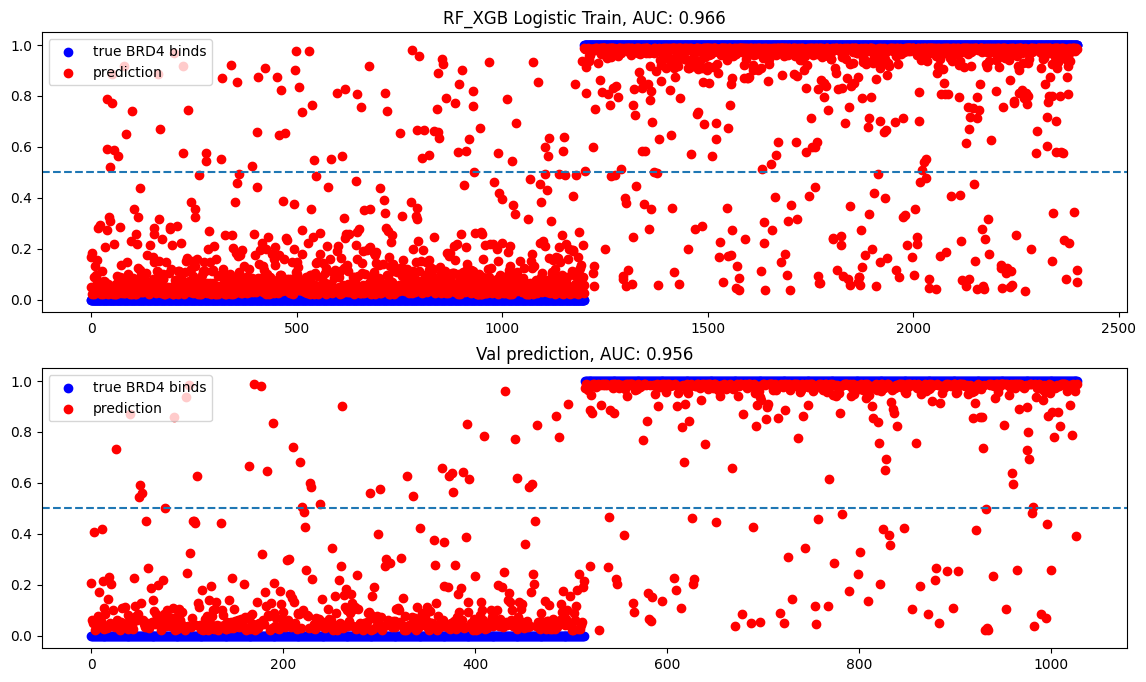

In [ ]:
l11,l12,l21,l22=np.sum(ytr==0),np.sum(ytr==1),np.sum(yte==0),np.sum(yte==1)


ytru = np.concatenate((ytr[ytr==0],ytr[ytr==1]))
ctr =np.concatenate((cm_final[ytr==0],cm_final[ytr==1]))

yteu = np.concatenate((yte[yte==0],yte[yte==1]))
cte =np.concatenate((ct_final[yte==0],ct_final[yte==1]))


plt.figure(figsize=(14,8))
plt.subplot(2,1,1)
plt.scatter(np.arange(l11+l12),ytru,color='b',label='true BRD4 binds')
plt.axhline(y=0.5,xmin=0,xmax=l11+l12,linestyle='--')
plt.scatter(np.arange(l11+l12),ctr,color='r',label='prediction')
plt.title(f"RF_XGB Logistic Train, AUC: {np.round(modelPerformance.loc[12,'Train AUC'],3)}")
plt.legend()
plt.subplot(2,1,2)
plt.scatter(np.arange(l21+l22),yteu,color='b',label='true BRD4 binds')
plt.axhline(y=0.5,xmin=0,xmax=l21+l22,linestyle='--')
plt.scatter(np.arange(l21+l22),cte,color='r',label='prediction')
plt.title(f"Val prediction, AUC: {np.round(modelPerformance.loc[12,'Val AUC'],3)}")
plt.legend()
plt.show()

In [ ]:
print('This is for the fusion logistic model 132 MF')

th=0.5
print('Training result - Threshold 0.5 -- not AUC')
print(clasrep(ytr,cm_final>th))
print(cfmatrix(ytr,cm_final>th))


print('Validation result - Threshold 0.5 -- not AUC')
print(clasrep(yte,ct_final>th))
print(cfmatrix(yte,ct_final>th))

This is for the fusion logistic model 132 MF
Training result - Threshold 0.5 -- not AUC
              precision    recall  f1-score   support

           0       0.89      0.93      0.91      1200
           1       0.93      0.89      0.91      1200

    accuracy                           0.91      2400
   macro avg       0.91      0.91      0.91      2400
weighted avg       0.91      0.91      0.91      2400

[[1115   85]
 [ 131 1069]]
Validation result - Threshold 0.5 -- not AUC
              precision    recall  f1-score   support

           0       0.87      0.92      0.89       514
           1       0.91      0.86      0.89       514

    accuracy                           0.89      1028
   macro avg       0.89      0.89      0.89      1028
weighted avg       0.89      0.89      0.89      1028

[[471  43]
 [ 70 444]]


In [ ]:
# averaging the two probabilities convex model

a = 0.5
cm_final=(1-a)*cmrf[:,0] + a*cmrf[:,1]
ct_final=(1-a)*ctrf[:,0] + a*ctrf[:,1]

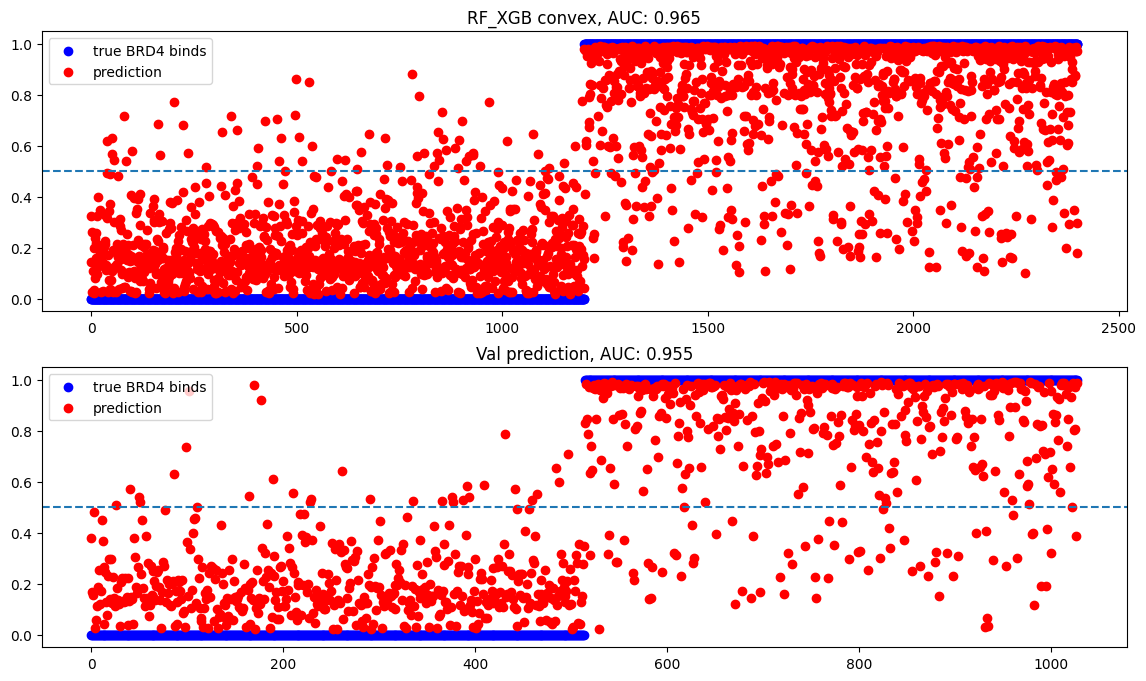

In [ ]:
l11,l12,l21,l22=np.sum(ytr==0),np.sum(ytr==1),np.sum(yte==0),np.sum(yte==1)


ytru = np.concatenate((ytr[ytr==0],ytr[ytr==1]))
ctr =np.concatenate((cm_final[ytr==0],cm_final[ytr==1]))

yteu = np.concatenate((yte[yte==0],yte[yte==1]))
cte =np.concatenate((ct_final[yte==0],ct_final[yte==1]))


plt.figure(figsize=(14,8))
plt.subplot(2,1,1)
plt.scatter(np.arange(l11+l12),ytru,color='b',label='true BRD4 binds')
plt.axhline(y=0.5,xmin=0,xmax=l11+l12,linestyle='--')
plt.scatter(np.arange(l11+l12),ctr,color='r',label='prediction')
plt.title(f"RF_XGB convex, AUC: {np.round(modelPerformance.loc[12,'Train AUC'],3)}")
plt.legend()
plt.subplot(2,1,2)
plt.scatter(np.arange(l21+l22),yteu,color='b',label='true BRD4 binds')
plt.axhline(y=0.5,xmin=0,xmax=l21+l22,linestyle='--')
plt.scatter(np.arange(l21+l22),cte,color='r',label='prediction')
plt.title(f"Val prediction, AUC: {np.round(modelPerformance.loc[12,'Val AUC'],3)}")
plt.legend()
plt.show()

In [ ]:
modelPerformance.loc[len(modelPerformance.index),:]=['RF_XGB','132F Convex.5',
                                                     Xtr.shape[0],100*np.sum(ytr)/Xtr.shape[0],roc_auc_score(ytr,cm_final),
                                                     Xte.shape[0],100*np.sum(yte)/Xte.shape[0],roc_auc_score(yte,ct_final)]

modelPerformance


,Model,#Parameters,Train Data points,Train positive fraction %,Train AUC,Val Data points,Val positive fraction %,Val AUC
0,Logistic_BPF,7,2400,50.0,0.783459,1028,50.0,0.781942
1,Logistic_SMF,5,2400,50.0,0.827317,1028,50.0,0.817344
2,RF_SMF,"Logistic 4 (10,4)",2400,50.0,0.827728,1028,50.0,0.820285
3,RF_SBMF,"23 AUC>0.6 (500,8)",2400,50.0,0.884209,1028,50.0,0.864423
4,RF_AllMF,"1024MF (500,8)",2400,50.0,0.974584,1028,50.0,0.947452
5,RF_SelMF,"375 F (500,6)",2400,50.0,0.954887,1028,50.0,0.93872
6,XGB_AllMF,"(317,2)",2400,50.0,0.969031,1028,50.0,0.958993
7,XGB_SelMF,"132MF (278,2)",2400,50.0,0.966066,1028,50.0,0.957153
8,RF_SelMF,"132F (278,2)",2400,50.0,0.897174,1028,50.0,0.891866
9,RF_SelMF,"132F (278,4)",2400,50.0,0.93041,1028,50.0,0.918674


In [ ]:
print('This is for the fusion convex 132 MF')

th=0.5
print('Training result - Threshold 0.5 -- not AUC')
print(clasrep(ytr,cm_final>th))
print(cfmatrix(ytr,cm_final>th))


print('Validation result - Threshold 0.5 -- not AUC')
print(clasrep(yte,ct_final>th))
print(cfmatrix(yte,ct_final>th))

This is for the fusion convex 132 MF
Training result - Threshold 0.5 -- not AUC
              precision    recall  f1-score   support

           0       0.88      0.95      0.91      1200
           1       0.94      0.87      0.90      1200

    accuracy                           0.91      2400
   macro avg       0.91      0.91      0.91      2400
weighted avg       0.91      0.91      0.91      2400

[[1135   65]
 [ 159 1041]]
Validation result - Threshold 0.5 -- not AUC
              precision    recall  f1-score   support

           0       0.87      0.94      0.90       514
           1       0.93      0.85      0.89       514

    accuracy                           0.90      1028
   macro avg       0.90      0.90      0.90      1028
weighted avg       0.90      0.90      0.90      1028

[[482  32]
 [ 75 439]]
